# OpenVINO example with Squeezenet Model

This notebook illustrates how you can serve [OpenVINO](https://software.intel.com/en-us/openvino-toolkit) optimized models for Imagenet with Seldon Core.

<img src="dog.jpeg"/>

## Run Seldon Core on Minikube

**The example below assumes Minikube 0.30.0 installed**

In [2]:
!minikube start --memory 4096 --disk-size 20g

Starting local Kubernetes v1.12.4 cluster...
Starting VM...
Getting VM IP address...
Moving files into cluster...
Setting up certs...
Connecting to cluster...
Setting up kubeconfig...
Stopping extra container runtimes...
Starting cluster components...
Verifying kubelet health ...
Verifying apiserver health ...Kubectl is now configured to use the cluster.
Loading cached images from config file.


Everything looks great. Please enjoy minikube!


In [3]:
!kubectl create namespace seldon

namespace/seldon created


In [4]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "minikube" modified.


In [5]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


In [6]:
!helm init

$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [7]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for deployment "tiller-deploy" rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


In [8]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd  --set usage_metrics.enabled=true
!helm install ../../../helm-charts/seldon-core --name seldon-core --set ambassador.enabled=true

NAME:   seldon-core-crd
LAST DEPLOYED: Mon Jan  7 12:56:17 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     5s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  1s

==> v1beta1/Deployment
NAME                        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-spartakus-volunteer  1        0        0           0          1s

==> v1/ServiceAccount
NAME                        SECRETS  AGE
seldon-spartakus-volunteer  1        1s

==> v1beta1/ClusterRole
NAME                        AGE
seldon-spartakus-volunteer  1s

==> v1beta1/ClusterRoleBinding
NAME                        AGE
seldon-spartakus-volunteer  1s


NOTES:
NOTES: TODO


NAME:   seldon-core
LAST DEPLOYED: Mon Jan  7 12:56:22 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/Role
NAME          AGE
seldon-local  0s
ambassador    0s

==> v1/RoleB

## (Optional) Install Jaeger

We will use the Jaeger All-in-1 resource found at the [Jaeger Kubernetes repo](https://github.com/jaegertracing/jaeger-kubernetes).

In [9]:
!kubectl create -f https://raw.githubusercontent.com/jaegertracing/jaeger-kubernetes/master/all-in-one/jaeger-all-in-one-template.yml -n seldon

deployment.extensions/jaeger-deployment created
service/jaeger-query created
service/jaeger-collector created
service/jaeger-agent created
service/zipkin created


### Start Jaeger UI

```
minikube service jaeger-query -n seldon
```

## Build Seldon base images with OpenVINO

In [ ]:
!cd ../../../wrappers/s2i/python_openvino && cp ../python/s2i . && \
docker build -f Dockerfile_openvino_base --build-arg http_proxy=$http_proxy --build-arg https_proxy=$https_proxy -t seldon_openvino_base:latest .

## Build Model, Combiner and Transformer Images

In [ ]:
!cd resources/model && s2i build -E environment_grpc . seldon_openvino_base:latest <your registry path>seldon-openvino-prediction:0.1

In [49]:
!cd resources/combiner && s2i build -E environment_grpc . seldon_openvino_base:latest <your registry path>/imagenet_combiner:0.1

---> Installing application source...
Build completed successfully


In [50]:
!cd resources/transformer && s2i build -E environment_grpc . seldon_openvino_base:latest seldonio/imagenet_transformer:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## Deploy Seldon Intel OpenVINO Graph



In [12]:
import sys
sys.path.append("../../../notebooks")
from visualizer import *

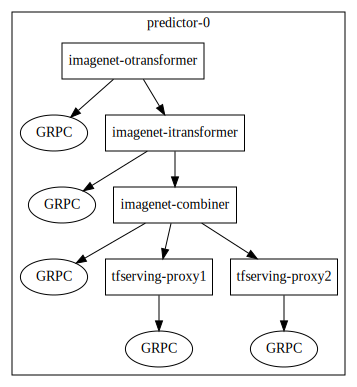

In [13]:
get_graph("seldon_ov_predict_ensemble.json")

In [ ]:
!pygmentize seldon_ov_predict_ensemble.json

In [51]:
!kubectl apply -f seldon_ov_predict_ensemble.json

persistentvolume/hostpath-pvc unchanged
persistentvolumeclaim/model-store-pvc unchanged
seldondeployment.machinelearning.seldon.io/openvino-model created


## Testing the pipeline

Expose ambassador API endpoint outside of the Kubernetes cluster or connect to it via `kubectl port-forward`.

Install python dependencies:

In [ ]:
!pip install -y sedon-core grpcio

Optionally expand `input_images.txt` to include bigger of a complete imagenet dataset in the same format: path to the image separated by the imagenet class number.

In [ ]:
!python seldon_grpc_client.py